In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
from collections import defaultdict
import numpy as np
import utils
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

from skmultilearn.model_selection import iterative_train_test_split

/home/joanna/miniconda3/envs/default-env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data_dir = "../../data/google_patents/24054-jp-patents"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 24054


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "title": str,
    "pdf": str,
    "description": List[str],      # should be concatenated
    "claims": List[str],
    "classifications": List[str],   # each string uses "\n" to separate the cluster ID and its description 
}
```

In [4]:
sample_doc_file = doc_files[2]
with open(sample_doc_file, "r") as f:
    sample_doc = json.load(f)
    print("Document attributes:", sample_doc.keys())

Document attributes: dict_keys(['title', 'pdf', 'classifications', 'description', 'claims'])


In [5]:
sample_doc["classifications"]

['A61N1/0456\nSpecially adapted for transcutaneous electrical nerve stimulation [TENS]',
 'A61N1/0526\nHead electrodes',
 'A61N1/0551\nSpinal or peripheral nerve electrodes',
 'A61N1/36017\nExternal stimulators, e.g. with patch electrodes with leads or electrodes penetrating the skin',
 'A61N1/36025\nExternal stimulators, e.g. with patch electrodes for treating a mental or cerebral condition',
 'A61N1/36031\nControl systems using physiological parameters for adjustment',
 'A61N1/36034\nControl systems specified by the stimulation parameters',
 'A61N1/36053\nImplantable neurostimulators for stimulating central or peripheral nerve system adapted for vagal stimulation',
 'A61N1/36064\nEpilepsy',
 'A61N1/36085\nEating disorders or obesity',
 'A61N1/36089\nAddiction or withdrawal from substance abuse such as alcohol or drugs',
 'A61N1/36096\nMood disorders, e.g. depression, anxiety or panic disorder',
 'A61N1/361\nPhantom sensations, e.g. tinnitus',
 'A61N1/36114\nCardiac control, e.g. by v

In [6]:
def tokens(segments):
    res = []
    for c in segments:
        for x in c.split():
            res.append(x)
    return res

def get_id(doc_file_name):
    x = os.path.basename(doc_file_name)
    return os.path.splitext(x)[0]
    
def get_content(doc):
    return " ".join(tokens(doc["claims"]))

def get_label(doc):
    res = set(x.split("\n")[0][:3] for x in doc["classifications"])
    return list(res)
    
def get_title(doc):
    return doc["title"]

def get_description(doc):
    return " ".join(tokens(doc["description"]))

def get_sample(doc, fname):
    return {
        "id": get_id(fname), "title": get_title(doc), 
        "desc": get_description(doc), "content": get_content(doc), 
        "labels": get_label(doc)
    }

In [7]:
"""
Extract samples from raw data
"""
samples = []
for fname in doc_files:
    with open(fname, "r") as fin:
        doc = json.load(fin)
        if get_label(doc):
            samples.append(get_sample(doc, fname))
            
print("Number of valid documents:", len(samples))

Number of valid documents: 23884


In [8]:
"""
Count number of samples/label and discard labels with < 500 samples
"""
def compute_frequency(samples):
    freq = {}
    for x in samples:
        for label in x["labels"]:
            freq[label] = freq.get(label, 0) + 1
    return freq

freq = compute_frequency(samples)
labels = set(k for k, v in freq.items() if v >= 500)
label_ids = {x : i for i, x in enumerate(labels)}
print("Number of labels:", len(labels))

Number of labels: 22


In [9]:
new_samples = []
for sample in tqdm(samples):
    sample["labels"] = [e for e in sample["labels"] if e in labels]
    if len(sample["labels"]) != 0:
        new_samples.append(sample)

samples = new_samples

100%|██████████| 23884/23884 [00:00<00:00, 1058212.63it/s]


## EDA

In [10]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,desc,content,labels
0,JP6856711B2,半導体装置,Description translated from 本発明は、酸化物半導体を用いる半導体...,ゲート電極層と、 前記ゲート電極層上にゲート絶縁層と、 前記ゲート絶縁層上に酸化物半導体層と...,"[G02, H01]"
1,JP6856704B2,医学的障害の治療のためのデバイス,Description translated from 関連出願の相互参照 [0001] 本...,医学的障害の治療のための三叉神経刺激のためのシステムであって、 パルス発生器と、 前記パルス...,[A61]
2,JP6856696B2,コンテナの管理及びスケジューリングのためのシステム,Description translated from 関連出願の相互参照 本出願は、「ＳＹ...,１つまたは複数のプロセッサと、 前記１つまたは複数のプロセッサによって実行される際、実行可能...,[G06]
3,JP6856695B2,タービン・カートリッジを備えるオーバーハング・タービン及び発電機システム,Description translated from （関連出願のデータ） [0001] ...,シャフトと、 ハウジングと、 複数の固定子板を含む少なくとも１つの固定子であって、前記複数の...,"[H02, Y02, Y10]"
4,JP6856694B2,Ｔｉｍ−３に対する抗体分子およびその使用,Description translated from 関連出願の相互参照 本出願は、米国仮...,（ａ）配列番号９のＶＨＣＤＲ１アミノ酸配列；配列番号１０のＶＨＣＤＲ２アミノ酸配列；および配...,"[Y02, G01, C07, A61]"
...,...,...,...,...,...
22838,JP3194731U,呼吸器及び呼吸器用選択素子,Description translated from 本考案は、気体混合物の処理、特に、人...,患者からの吐出気体のための気体経路に気体分離膜を有し、 その気体分離膜は、希ガスが比較的低浸...,"[B01, A61]"
22839,JP3194569U,保護カバー,Description translated from 本考案は、保護カバーに関するものであ...,収容部と、 前記収容部に設置される緩和部と、 を備えてなる保護カバーであって、 前記収容部に...,[H04]
22840,JP3194297U,自動車用及び産業用のモーション感知制御装置,Description translated from 本願の技術は、自動車用及び産業用の制...,組み込み可能なモーション感知制御装置であって、 眺められている景色の立体的なイメージ情報を提...,"[G06, G01, H04]"
22841,JP3193976U,過熱破壊式安全構造及び過熱破壊式安全構造を備えるコンセントとプラグ,Description translated from 本考案は、動作温度が高くなりすぎた時...,２つの導電部材と、熱変形温度下で変形破壊する位置規制部材とを備える過熱破壊式安全構造であって...,[H01]


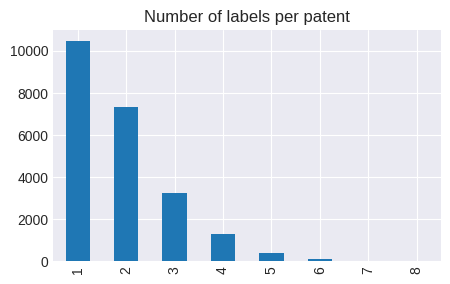

In [11]:
fig = plt.figure(figsize=(5, 3))
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()

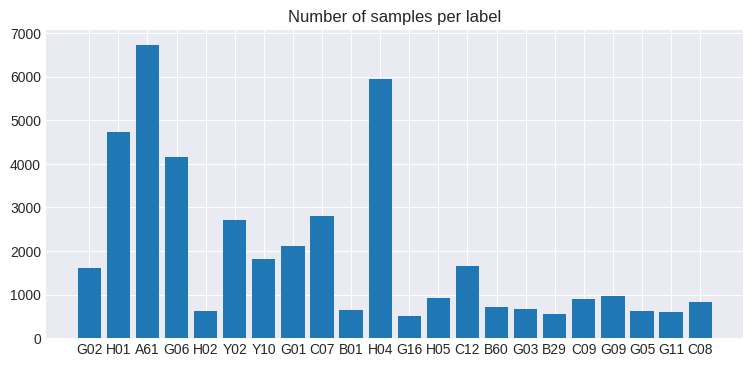

In [12]:
freq = compute_frequency(samples)
fig = plt.figure(figsize=(9, 4))
plt.bar(freq.keys(), freq.values())
plt.title("Number of samples per label")
plt.show()

In [13]:
df["labels"].apply(lambda x : len(x)).describe()

count    22843.000000
mean         1.873222
std          1.037449
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: labels, dtype: float64

In [14]:
threshold = min_freq = min(freq.values())
print("Threshold:", threshold)

Threshold: 506


In [15]:
class_label = defaultdict(set)
sample_label = defaultdict(set)

for rid, labels in df["labels"].iteritems():
    sample_label[rid].update(labels)
    for x in labels:
        class_label[x].add(rid)

selected_samples = set()
selected_labels = set()

for label in sorted(freq, key=lambda x : freq.get(x)):
    if len(class_label[label]) == min_freq:
        selected_samples.update(class_label[label])
        selected_labels.add(label)
        continue

    # compute number of samples needed to be drawn (ignoring duplicated samples)
    included_samples = class_label[label].intersection(selected_samples)
    sample_size = max(0, threshold - len(included_samples))

    # samples that contain least unselected labels have the highest priority
    sample_space = list(class_label[label].difference(selected_samples))
    sorted_sample_space = sorted(sample_space, key=lambda x : len(sample_label[x].difference(selected_labels)))

    #selected_samples.update(random_state.choice(sample_space, sample_size, replace=False))
    selected_samples.update(sorted_sample_space[:sample_size])
    selected_labels.add(label)

new_samples = [x for i, x in enumerate(samples) if i in selected_samples]

In [16]:
print(len(selected_samples))

6048


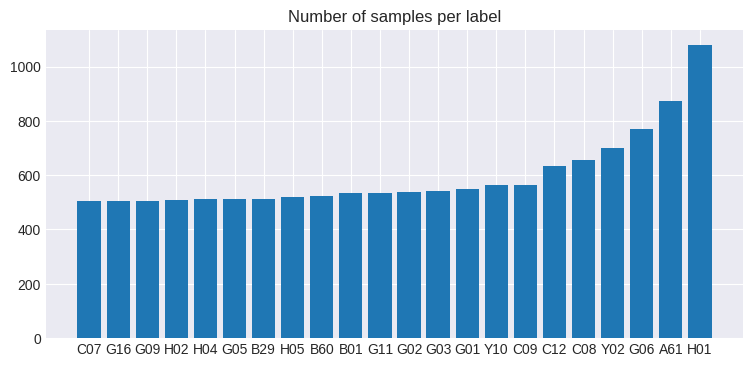

count      22.000000
mean      597.409091
std       144.809451
min       506.000000
25%       511.500000
50%       537.500000
75%       615.500000
max      1080.000000
dtype: float64

In [17]:
new_freq = compute_frequency(new_samples)
new_freq = {k: new_freq[k] for k in sorted(new_freq, key=new_freq.get)}
fig = plt.figure(figsize=(9, 4))
plt.bar(new_freq.keys(), new_freq.values())
plt.title("Number of samples per label")
plt.show()
pd.Series(new_freq).describe()

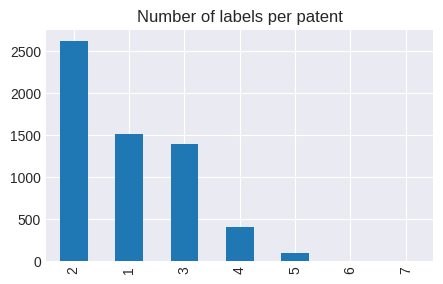

count    6048.000000
mean        2.173115
std         0.956966
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: labels, dtype: float64

In [18]:
new_df = pd.DataFrame(new_samples)
fig = plt.figure(figsize=(5, 3))
ax = new_df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()
new_df["labels"].apply(lambda x : len(x)).describe()

## Data Splitting

In [19]:
df = new_df
samples = new_samples

In [20]:
X_raw = np.array([[x] for x in samples])
y_raw = np.matrix([utils.get_onehot(x["labels"], label_ids) for x in samples])
X, y = {}, {}
y_raw.shape

(6048, 22)

In [21]:
X["train"], y["train"], X["test"], y["test"] = iterative_train_test_split(X_raw, y_raw, test_size=0.1)

In [22]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["test"] == 1)[1]).tolist()))

set()

In [23]:
X["train"], y["train"], X["dev"], y["dev"] = iterative_train_test_split(X["train"], y["train"], test_size=len(y["test"]) / len(y["train"]))

In [24]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["dev"] == 1)[1]).tolist()))

set()

In [25]:
samples = []
for data_type in ("train", "dev", "test"):
    for sample in X[data_type]:
        sample = sample[0]
        sample["is_train"] = sample["is_dev"] = sample["is_test"] = False
        sample[f"is_{data_type}"] = True
        samples.append(sample)

In [26]:
df = pd.DataFrame(samples)
df.head()

,id,title,desc,content,labels,is_train,is_dev,is_test
0,JP6856694B2,Ｔｉｍ−３に対する抗体分子およびその使用,Description translated from 関連出願の相互参照 本出願は、米国仮...,（ａ）配列番号９のＶＨＣＤＲ１アミノ酸配列；配列番号１０のＶＨＣＤＲ２アミノ酸配列；および配...,"[Y02, G01, C07, A61]",True,False,False
1,JP6855650B2,自動運転制御装置及び車両,Description translated from 関連出願の相互参照 本国際出願は、２...,車両に搭載される自動運転制御装置であって、 前記車両の周囲の情報である周囲情報を取得するよう...,[B60],True,False,False
2,JP6855432B2,遷移金属／ゼオライトｓｃｒ触媒,Description translated from 本発明は、例えば車両リーンバーン内燃...,車両リーンバーン内燃機関のための排気システムであって、 流れる排ガスを通過させる導管と、 窒...,"[Y02, B01]",True,False,False
3,JP6855366B2,プラスチック部品を製造する方法、プラスチック部品、および靴,Description translated from 本発明は、プラスチック部品、特にスポ...,プラスチック部品を製造する方法であって、 ａ．発泡材料の粒子を含む第１の材料を型に装填するス...,[B29],True,False,False
4,JP6854836B2,共押出しされた、多層電池セパレーター,Description translated from 本明細書に開示される電池セパレーター...,共押出しされたポリオレフィン系ミクロポーラス多層のドライ延伸された膜である、リチウムイオン電...,"[Y02, B29, H01]",True,False,False


In [27]:
num_words = int(df["content"].apply(lambda x : len(x.split())).mean())
num_chars = int(df["content"].apply(lambda x : sum(1 for e in x if e.strip())).mean())
num_train = len(df[df["is_train"] == True])
num_val = len(df[df["is_dev"] == True])
num_test = len(df[df["is_test"] == True])
num_labels = len(label_ids)
print("{} & {} & {} & {} & {} & {}".format(num_train, num_val, num_test, num_words, num_chars, num_labels))

4863 & 582 & 603 & 41 & 2454 & 22


In [28]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(4863, 582, 603)

In [29]:
# Check if there is any empty patent
df[df["content"].apply(lambda x : len(x)) == 0]

,id,title,desc,content,labels,is_train,is_dev,is_test


## Save data

In [30]:
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")
label_ids = utils.load_json(save_label_path)

100%|██████████| 6048/6048 [00:03<00:00, 1985.93it/s]
